# EDA: Accelerometer Action Classification
This notebook contains basic EDA for the provided CSVs.

Loaded 15 files; total rows = 1926896


,seq,x,y,z,label,participant
0,0.0,1502,2215,2153,1,1
1,1.0,1667,2072,2047,1,1
2,2.0,1611,1957,1906,1,1
3,3.0,1601,1939,1831,1,1
4,4.0,1643,1965,1879,1,1


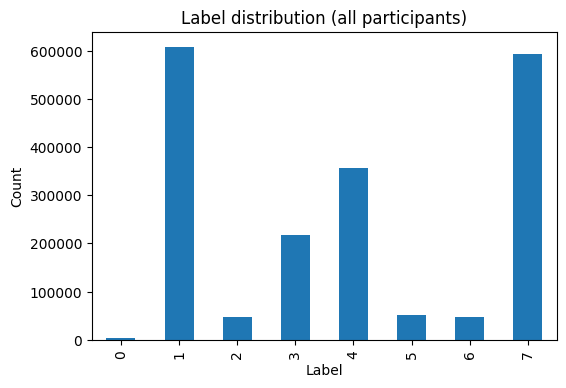

In [25]:
import os
import pandas as pd, glob, matplotlib.pyplot as plt

data_dir = r"C:\Users\USER\Downloads\action_classification_repo\action-classification\data"
files = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
dfs = [pd.read_csv(f, header=None, names=['seq','x','y','z','label']).assign(participant=os.path.basename(f).split('.')[0]) for f in files]

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print('Loaded', len(files), 'files; total rows =', len(df))
    display(df.head())

    # label distribution
    plt.figure(figsize=(6,4))
    df['label'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label distribution (all participants)')
    plt.show()
else:
    print(f"No CSV files found in '{data_dir}' directory.")

In [26]:
print(df.isnull().sum())
print("Any NaNs?", df.isnull().values.any())
print("Describe:", df.describe())

seq            0
x              0
y              0
z              0
label          0
participant    0
dtype: int64
Any NaNs? False
Describe:                 seq             x             y             z         label
count  1.926896e+06  1.926896e+06  1.926896e+06  1.926896e+06  1.926896e+06
mean   6.711283e+04  1.987652e+03  2.382523e+03  1.970596e+03  3.882898e+00
std    4.146191e+04  1.113578e+02  1.003151e+02  9.445893e+01  2.443402e+00
min    0.000000e+00  2.820000e+02  2.000000e+00  1.000000e+00  0.000000e+00
25%    3.211400e+04  1.904000e+03  2.337000e+03  1.918000e+03  1.000000e+00
50%    6.422900e+04  1.992000e+03  2.367000e+03  1.988000e+03  4.000000e+00
75%    9.839400e+04  2.076000e+03  2.413000e+03  2.032000e+03  7.000000e+00
max    1.667400e+05  3.828000e+03  4.095000e+03  4.095000e+03  7.000000e+00


#  Visualize Feature Distributions

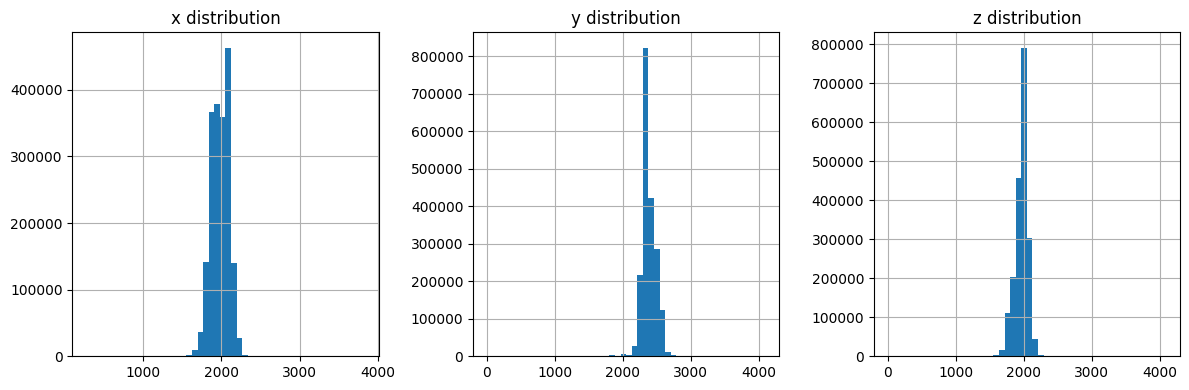

In [27]:
plt.figure(figsize=(12,4))
for i, col in enumerate(['x','y','z']):
    plt.subplot(1,3,i+1)
    df[col].hist(bins=50)
    plt.title(f'{col} distribution')
plt.tight_layout()
plt.show()

# Visualize Sample Windows for Different Actions

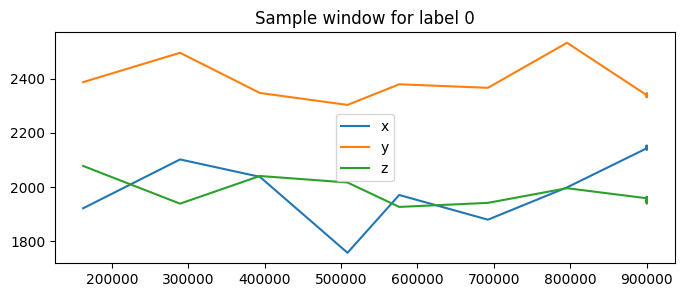

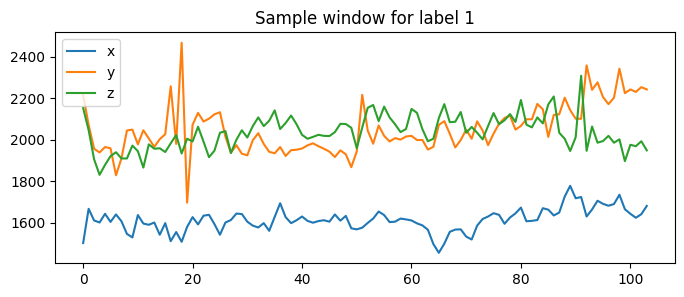

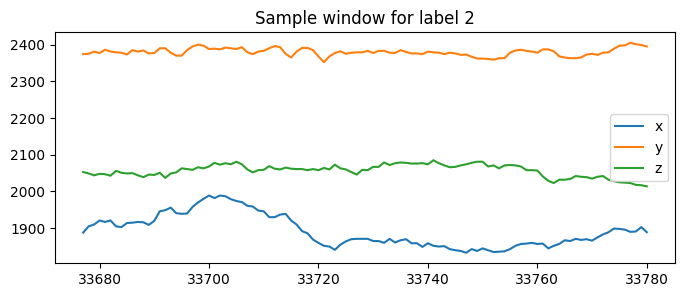

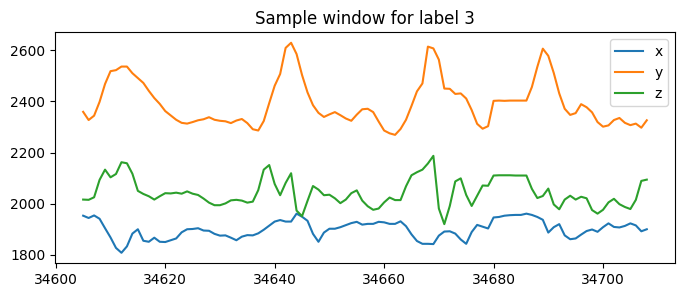

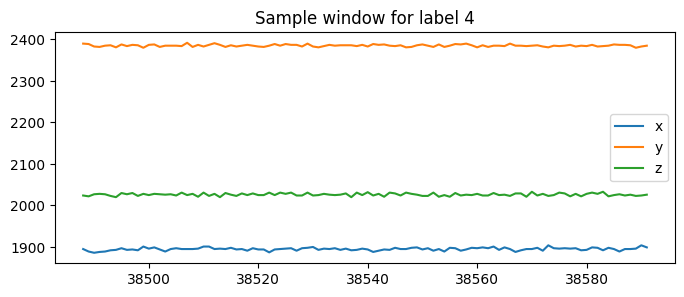

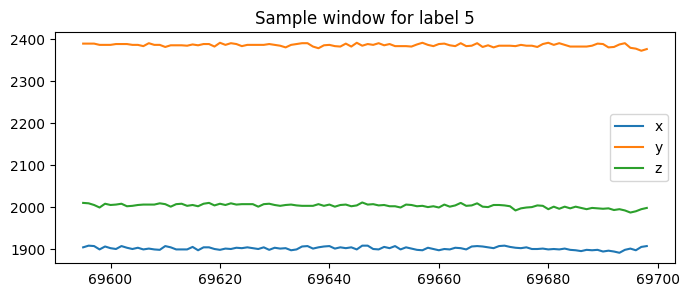

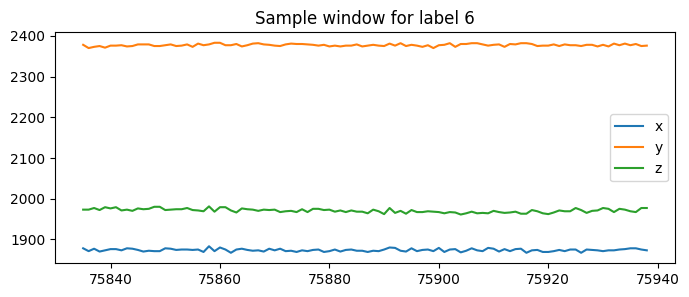

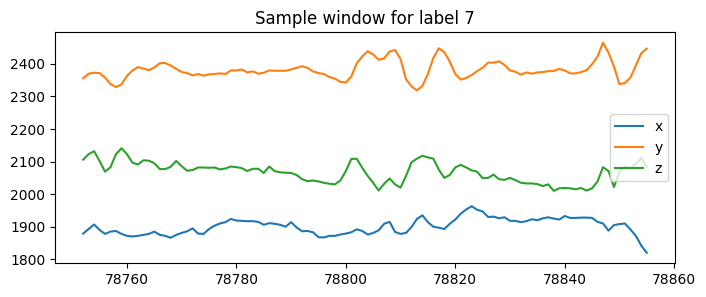

In [28]:
for label in sorted(df['label'].unique()):
    sample = df[df['label']==label].head(104)
    plt.figure(figsize=(8,3))
    plt.plot(sample['x'], label='x')
    plt.plot(sample['y'], label='y')
    plt.plot(sample['z'], label='z')
    plt.title(f'Sample window for label {label}')
    plt.legend()
    plt.show()

# Correlation Analysis

          x         y         z
x  1.000000  0.364761  0.010835
y  0.364761  1.000000  0.346573
z  0.010835  0.346573  1.000000


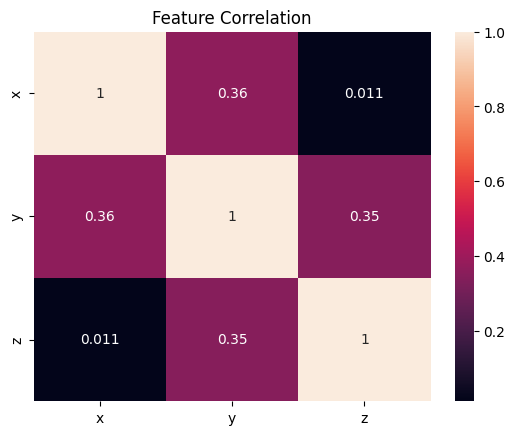

In [29]:
corr = df[['x','y','z']].corr()
print(corr)
import seaborn as sns
sns.heatmap(corr, annot=True)
plt.title('Feature Correlation')
plt.show()

#  Label Mapping

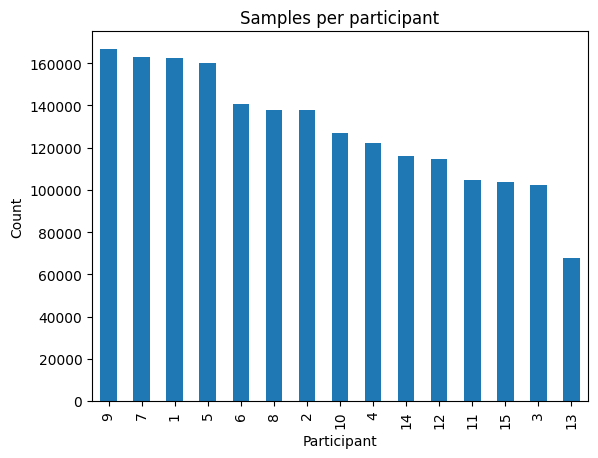

In [30]:
df['participant'].value_counts().plot(kind='bar')
plt.title('Samples per participant')
plt.xlabel('Participant')
plt.ylabel('Count')
plt.show()

In [33]:
for col in ['x', 'y', 'z']:
    print(f"{col} outliers:", df[(df[col] < df[col].quantile(0.01)) | (df[col] > df[col].quantile(0.99))].shape[0])

x outliers: 38513
y outliers: 38473
z outliers: 38251


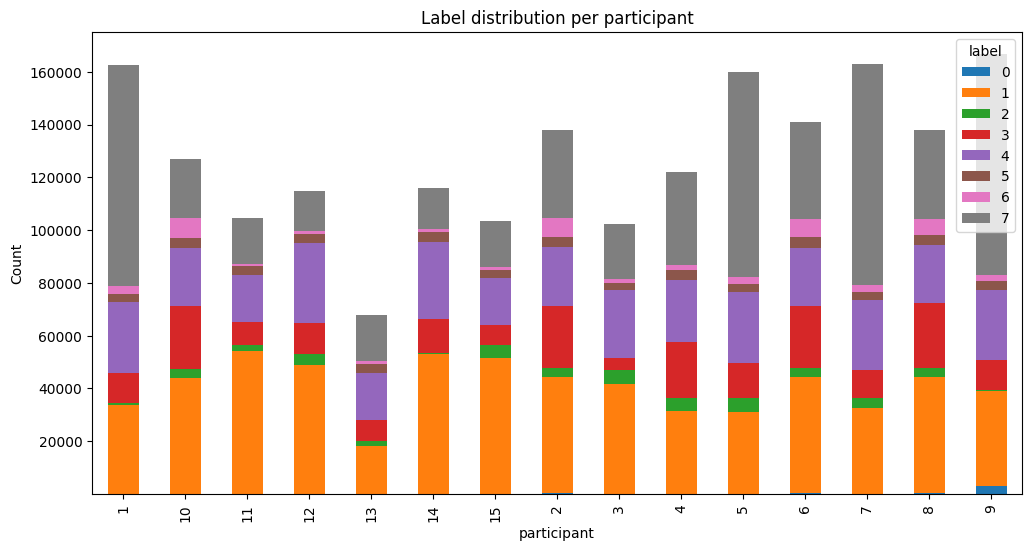

In [34]:
pd.crosstab(df['participant'], df['label']).plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Label distribution per participant')
plt.ylabel('Count')
plt.show()

1. Summarize EDA Insights
No missing values: Data is clean.
Feature distributions: x, y, z are roughly normal, but check for outliers.
Label imbalance: Some actions (labels 1 and 7) dominate; others are underrepresented.
Participant imbalance: Some participants have much more data.
Feature correlation: Moderate correlation between axes.
Outliers: Each axis has ~38,000 outliers (about 2% of data).

2. Recommendations for Modeling
A. Handle Outliers
Consider removing or capping outliers, or use robust scaling (e.g., StandardScaler, RobustScaler).
You can filter out rows outside the 1st and 99th percentiles for each axis.
B. Address Class Imbalance
Use stratified sampling for train/test split.
Consider class weights in your model (RandomForest supports class_weight='balanced').
Optionally, try oversampling minority classes (e.g., SMOTE) if performance is poor.


3. Next Steps 
Preprocessing:
Remove or cap outliers.
Normalize or scale features.


After outlier removal, shape: (1829139, 6)


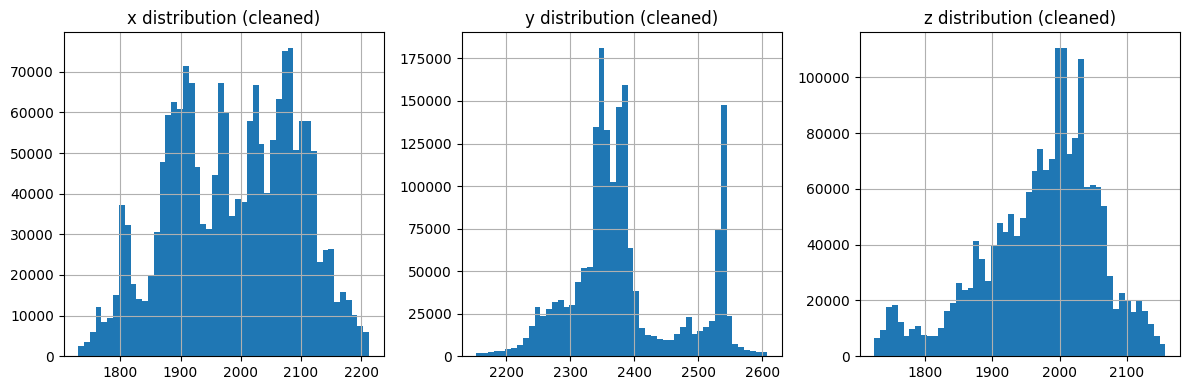

In [35]:
# Step 1: Calculate thresholds
outlier_limits = {}
for col in ['x', 'y', 'z']:
    outlier_limits[col] = (df[col].quantile(0.01), df[col].quantile(0.99))

# Step 2: Filter out outliers
for col in ['x', 'y', 'z']:
    lower, upper = outlier_limits[col]
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("After outlier removal, shape:", df.shape)

# Step 3: Visualize distributions again (optional)
plt.figure(figsize=(12,4))
for i, col in enumerate(['x','y','z']):
    plt.subplot(1,3,i+1)
    df[col].hist(bins=50)
    plt.title(f'{col} distribution (cleaned)')
plt.tight_layout()
plt.show()

In [36]:
import numpy as np

# Pre-Processing and Feature Engineering

In [37]:
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

# Normalize or Scale Features

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['x', 'y', 'z', 'magnitude']] = scaler.fit_transform(df[['x', 'y', 'z', 'magnitude']])

# Split Data for Training and Testing

In [39]:
from sklearn.model_selection import train_test_split

X = df[['x', 'y', 'z', 'magnitude']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.25      0.20       725
           1       0.87      0.85      0.86    115562
           2       0.26      0.26      0.26      8732
           3       0.52      0.44      0.48     41805
           4       0.61      0.68      0.64     63882
           5       0.26      0.19      0.22      9496
           6       0.32      0.25      0.28      9441
           7       0.75      0.78      0.77    116185

    accuracy                           0.71    365828
   macro avg       0.47      0.46      0.46    365828
weighted avg       0.70      0.71      0.70    365828

[[  178   205    12    49   128     9    17   127]
 [  565 98447  4379  1879  4210   370   314  5398]
 [   21  2481  2231   591  1920    56    50  1382]
 [   94  2171   402 18322  8303  2157  1169  9187]
 [   83  4472   445  5096 43614   729   451  8992]
 [    4   731    37  1373  3502  1779   415  1655]
 [   24   364    53   987  1749   499  2390

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [19]:
model.fit(X_res, y_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# Predict on the original test set
y_pred = model.predict(X_test)

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.07      0.22      0.10       725
           1       0.88      0.84      0.86    115562
           2       0.19      0.31      0.23      8732
           3       0.48      0.46      0.47     41805
           4       0.60      0.56      0.58     63882
           5       0.15      0.25      0.19      9496
           6       0.21      0.33      0.26      9441
           7       0.79      0.73      0.76    116185

    accuracy                           0.67    365828
   macro avg       0.42      0.46      0.43    365828
weighted avg       0.70      0.67      0.69    365828

[[  161   250    17    59    89    26    25    98]
 [  648 97582  4461  2262  3836  1304   753  4716]
 [   49  2394  2697   663  1428   297   223   981]
 [  222  1822  1343 19227  6940  3001  1968  7282]
 [  617  3385  3220  6856 35641  5033  3001  6129]
 [   76   576   308  1760  2561  2339   663  1213]
 [   69   299   203  1128  1354   748  3097

In [21]:
import joblib

joblib.dump(model, 'random_forest_model.joblib')
print("Model saved to random_forest_model.joblib")

Model saved to random_forest_model.joblib


In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = df[['x', 'y', 'z', 'magnitude']]
y = df['label']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)

scores = cross_val_score(model, X, y, cv=skf, scoring='f1_weighted')  # or 'accuracy', 'f1_macro'
print("Stratified K-Fold F1 (weighted) scores:", scores)
print("Mean F1 (weighted):", scores.mean())

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model.predict(X.iloc[test_idx])
    print(f"\nFold {fold} classification report:")
    print(classification_report(y.iloc[test_idx], y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf, param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1, verbose=2
)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1 (weighted):", grid_search.best_score_)

In [2]:
import pandas as pd

# Load a CSV file (e.g., 1.csv)
df_sample = pd.read_csv('../data/1.csv', header=None, names=['seq', 'x', 'y', 'z', 'label'])

# Extract the first 104 rows as a sample window
sample_window = df_sample.head(104)

# Save only the features (x, y, z) to sample_window.csv
sample_window[['x', 'y', 'z']].to_csv('../sample_window.csv', index=False)

In [3]:
sample_window

,seq,x,y,z,label
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1
...,...,...,...,...,...
99,99.0,1665,2225,1897,1
100,100.0,1643,2243,1976,1
101,101.0,1624,2231,1969,1
102,102.0,1641,2254,1993,1
